In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
from torchinfo import summary
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.result_loader import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
from ml_utilities.data.data_utils import show_images
from ml_utilities.data.datasetgenerator import DatasetGenerator
from ml_utilities.torch_models import get_model_config, get_model_class

# 18.0 Fashion-MNIST Lenet, Conv, Resnet

In this notebook I want to train a different models on Fashion-MNIST.

The models I want to train are:
- Lenet
- Conv-4
- Resnet-20

## Setup Models and Data

In [2]:
data_cfg = """
data:
  dataset: fashion_mnist
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data
  dataset_split:
    train_val_split: 0.9
"""
data_cfg = OmegaConf.create(data_cfg)

In [5]:
datagen = DatasetGenerator(**data_cfg.data)
datagen.generate_dataset()

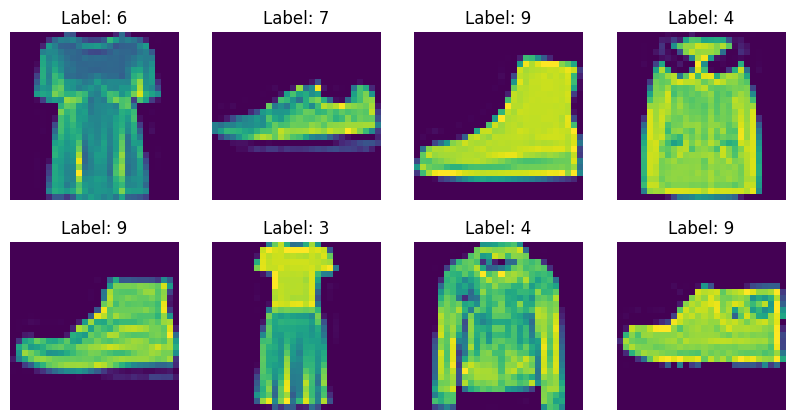

In [6]:
show_images(datagen.train_split, num_images=10, shuffle=False)

In [7]:
datagen.train_split[0][0].shape

torch.Size([1, 28, 28])

### Conv-4

In [2]:
model_cfg = OmegaConf.create({})
model_cfg.model = get_model_config('conv4_omniglot_without_bn') # conv4_omniglot_with_bn
model_class = get_model_class(model_cfg.model.name)
model = model_class(**model_cfg.model.model_kwargs)

In [26]:
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 5]                    --
├─Sequential: 1-1                        [1, 5]                    --
│    └─Sequential: 2-1                   [1, 64, 13, 13]           --
│    │    └─Conv2d: 3-1                  [1, 64, 26, 26]           640
│    │    └─ReLU: 3-2                    [1, 64, 26, 26]           --
│    │    └─MaxPool2d: 3-3               [1, 64, 13, 13]           --
│    └─Sequential: 2-2                   [1, 64, 5, 5]             --
│    │    └─Conv2d: 3-4                  [1, 64, 11, 11]           36,928
│    │    └─ReLU: 3-5                    [1, 64, 11, 11]           --
│    │    └─MaxPool2d: 3-6               [1, 64, 5, 5]             --
│    └─Sequential: 2-3                   [1, 64, 3, 3]             --
│    │    └─Conv2d: 3-7                  [1, 64, 3, 3]             36,928
│    │    └─ReLU: 3-8                    [1, 64, 3, 3]             --
│    └

In [22]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [0,1]
  runs_per_gpu: 3
  # wandb:
  #   init:
  #     tags:
  #     - ${config.experiment_data.experiment_tag}_exps
  #     - run_handler
  #     notes: null
  #     group: ${config.experiment_data.experiment_tag}
  #     job_type: run_handler

seeds: [0]

# sweep:
#   type: grid
#   axes: 
#   - parameter: model.model_cfg
#     vals: [conv4_mnist_with_bn, conv4_mnist_without_bn]
#   - parameter: trainer.optimizer_scheduler.optimizer_kwargs.lr
#     vals: [1.0, 0.5, 0.1, 0.05]
#   - parameter: trainer.optimizer_scheduler.optimizer_kwargs.weight_decay
#     vals: [0.0, 0.0001, 0.001]

sweep:
  type: grid
  axes: 
  - parameter: model.model_cfg
    vals: [conv4_mnist_with_bn, conv4_mnist_without_bn]
  - parameter: trainer.optimizer_scheduler.lr_scheduler_kwargs.milestones
    vals: [[12e3, 18e3], [8e3, 16e3], [10e3, 15e3, 20e3]]
  # - parameter: trainer.optimizer_scheduler.optimizer_kwargs.weight_decay
  #   vals: [0.0, 0.0001, 0.001]

start_num: 4

config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: tflearning
    experiment_tag: '18.0'
    experiment_type: startnum_${start_num}
    experiment_name: fmnist-${config.experiment_data.experiment_tag}.${start_num}-conv4-hypsearch
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
    watch:
      log: null
      log_freq:

  model:
    model_cfg: conv4_mnist_with_bn

  trainer:
    training_setup: supervised
    n_steps: 24e3
    log_train_step_every: 1
    log_additional_logs: true
    val_every: 500
    save_every: 64000
    early_stopping_patience: 64e3
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.05
        momentum: 0.9
        weight_decay: 0.0
      lr_scheduler_name: MultiStepLR
      lr_scheduler_kwargs:
        milestones: [12e3, 18e3]
        gamma: 0.1
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4

  data:
    dataset: fashion_mnist
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
"""
cfg = OmegaConf.create(config_yaml)

In [14]:
run_command = REPO.create_experiment(cfg, override=True)
print(run_command)

python run_sweep.py --config-name fmnist-18.0.4-conv4-hypsearch.yaml


In [23]:
sweepr_conv4 = REPO.get_output_loader(cfg)
print(sweepr_conv4)

Exp. Tag(start_num): 18.0(4)
Exp. Name: fmnist-18.0.4-conv4-hypsearch
Training setup: supervised
Model name: conv4_omniglot_with_bn
Dataset name: fashion_mnist
Sweep type: grid
  model.model_cfg: ['conv4_mnist_with_bn', 'conv4_mnist_without_bn']
  trainer.optimizer_scheduler.lr_scheduler_kwargs.milestones: [[12000.0, 18000.0], [8000.0, 16000.0], [10000.0, 15000.0, 20000.0]]
Seeds: [0]
Num. jobs: 6
Config updated: 2023-01-26 11:08:41
Sweep started:  2023-01-26 11:09:11



In [24]:
sweepr_conv4.get_summary().sort_values('best_val_score', ascending=False)

,best_train_step,best_val_score,model.model_cfg,trainer.optimizer_scheduler.lr_scheduler_kwargs.milestones,seed
fmnist-18.0.4-conv4-hypsearch--model_cfg-conv4_mnist_with_bn-milestones-8000.0_16000.0-seed-0--230126_110930,8500,0.917000,conv4_mnist_with_bn,"[8000.0, 16000.0]",0
fmnist-18.0.4-conv4-hypsearch--model_cfg-conv4_mnist_with_bn-milestones-10000.0_15000.0_20000.0-seed-0--230126_110925,4500,0.915833,conv4_mnist_with_bn,"[10000.0, 15000.0, 20000.0]",0
fmnist-18.0.4-conv4-hypsearch--model_cfg-conv4_mnist_with_bn-milestones-12000.0_18000.0-seed-0--230126_110929,4500,0.915833,conv4_mnist_with_bn,"[12000.0, 18000.0]",0
fmnist-18.0.4-conv4-hypsearch--model_cfg-conv4_mnist_without_bn-milestones-10000.0_15000.0_20000.0-seed-0--230126_110922,12000,0.909167,conv4_mnist_without_bn,"[10000.0, 15000.0, 20000.0]",0
fmnist-18.0.4-conv4-hypsearch--model_cfg-conv4_mnist_without_bn-milestones-8000.0_16000.0-seed-0--230126_110928,9000,0.908833,conv4_mnist_without_bn,"[8000.0, 16000.0]",0
fmnist-18.0.4-conv4-hypsearch--model_cfg-conv4_mnist_without_bn-milestones-12000.0_18000.0-seed-0--230126_110931,14000,0.908167,conv4_mnist_without_bn,"[12000.0, 18000.0]",0


In [25]:
sweepr_conv4.get_failed_jobs()

([], {})

### Lenet

In [21]:
model_cfg = OmegaConf.create({})
model_cfg.model = get_model_config('lenet_300_100_relu_mnist')
model_class = get_model_class(model_cfg.model.name)
model = model_class(**model_cfg.model.model_kwargs)

In [22]:
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FC                                       [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 300]                  235,500
│    └─ReLU: 2-3                         [1, 300]                  --
│    └─Linear: 2-4                       [1, 100]                  30,100
│    └─ReLU: 2-5                         [1, 100]                  --
│    └─Linear: 2-6                       [1, 10]                   1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
Total mult-adds (M): 0.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.07
Estimated Total Size (MB): 1.07

In [17]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [2, 3]
  runs_per_gpu: 3
  # wandb:
  #   init:
  #     tags:
  #     - ${config.experiment_data.experiment_tag}_exps
  #     - run_handler
  #     notes: null
  #     group: ${config.experiment_data.experiment_tag}
  #     job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: trainer.optimizer_scheduler.optimizer_kwargs.lr
    vals: [0.001, 0.005, 0.01, 1e-4]
  - parameter: trainer.optimizer_scheduler.optimizer_kwargs.weight_decay
    vals: [0.0, 0.0001, 0.001]

start_num: 0

config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: tflearning
    experiment_tag: '18.1'
    experiment_type: startnum_${start_num}
    experiment_name: fmnist-${config.experiment_data.experiment_tag}.${start_num}-lenet
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
    watch:
      log: null
      log_freq:

  model:
    model_cfg: lenet_300_100_relu_mnist

  trainer:
    training_setup: supervised
    n_steps: 24e3
    log_train_step_every: 1
    log_additional_train_step_every_multiplier: 1
    log_additional_logs: true
    val_every: 500
    save_every: 24e3
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: AdamW
      optimizer_kwargs:
        lr: 0.001
        weight_decay: 0.0
      # lr_scheduler_name: MultiStepLR
      # lr_scheduler_kwargs:
      #   milestones: [32e3, 48e3]
      #   gamma: 0.1
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4

  data:
    dataset: fashion_mnist
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
"""
cfg = OmegaConf.create(config_yaml)

In [36]:
run_command = REPO.create_experiment(cfg, override=False)
print(run_command)

python run_sweep.py --config-name fmnist-18.1.0-lenet.yaml


In [18]:
sweepr = REPO.get_output_loader(cfg)

In [21]:
sweepr.get_summary().sort_values('best_val_score', ascending=False)

,best_train_step,best_val_score,trainer.optimizer_scheduler.optimizer_kwargs.lr,trainer.optimizer_scheduler.optimizer_kwargs.weight_decay,seed
fmnist-18.1.0-lenet--lr-0.001-weight_decay-0-seed-0--230126_093209,7000,0.903167,0.0010,0.0000,0
fmnist-18.1.0-lenet--lr-0.001-weight_decay-0.001-seed-0--230126_093223,9500,0.899833,0.0010,0.0010,0
fmnist-18.1.0-lenet--lr-0.001-weight_decay-0.0001-seed-0--230126_093219,9500,0.899500,0.0010,0.0001,0
fmnist-18.1.0-lenet--lr-0.0001-weight_decay-0.001-seed-0--230126_092623,18000,0.897500,0.0001,0.0010,0
fmnist-18.1.0-lenet--lr-0.0001-weight_decay-0-seed-0--230126_092622,14000,0.896167,0.0001,0.0000,0
fmnist-18.1.0-lenet--lr-0.0001-weight_decay-0.0001-seed-0--230126_092619,14000,0.896167,0.0001,0.0001,0
fmnist-18.1.0-lenet--lr-0.005-weight_decay-0.0001-seed-0--230126_092624,8500,0.894000,0.0050,0.0001,0
fmnist-18.1.0-lenet--lr-0.005-weight_decay-0.001-seed-0--230126_093225,15500,0.891500,0.0050,0.0010,0
fmnist-18.1.0-lenet--lr-0.005-weight_decay-0-seed-0--230126_093206,22000,0.889000,0.0050,0.0000,0
fmnist-18.1.0-lenet--lr-0.01-weight_decay-0-seed-0--230126_093224,20000,0.885167,0.0100,0.0000,0


### Resnet20

In [23]:
model_cfg = OmegaConf.create({})
model_cfg.model = get_model_config('resnet20-mnist-B')
model_class = get_model_class(model_cfg.model.name)
model = model_class(**model_cfg.model.model_kwargs)

In [24]:
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                             Output Shape              Param #
Resnet                                             [1, 10]                   --
├─Sequential: 1-1                                  [1, 10]                   --
│    └─Sequential: 2-1                             [1, 16, 28, 28]           --
│    │    └─Conv2d: 3-1                            [1, 16, 28, 28]           144
│    │    └─BatchNorm2d: 3-2                       [1, 16, 28, 28]           32
│    │    └─ReLU: 3-3                              [1, 16, 28, 28]           --
│    └─Sequential: 2-2                             [1, 64, 7, 7]             --
│    │    └─Sequential: 3-4                        [1, 16, 28, 28]           14,016
│    │    └─Sequential: 3-5                        [1, 32, 14, 14]           51,648
│    │    └─Sequential: 3-6                        [1, 64, 7, 7]             205,696
│    └─AdaptiveAvgPool2d: 2-3                      [1, 64, 1, 1]             --
│    └─Sequential: 2-

### Config file

In [2]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [0,1,2,3]
  runs_per_gpu: 3
  # wandb:
  #   init:
  #     tags:
  #     - ${config.experiment_data.experiment_tag}_exps
  #     - run_handler
  #     notes: null
  #     group: ${config.experiment_data.experiment_tag}
  #     job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: trainer.optimizer_scheduler.optimizer_kwargs.lr
    vals: [1.0, 0.5, 0.1, 0.05]
  - parameter: trainer.optimizer_scheduler.optimizer_kwargs.weight_decay
    vals: [0.0, 0.0001, 0.001]
    
start_num: 0

config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: tflearning
    experiment_tag: '18.2'
    experiment_type: startnum_${start_num}
    experiment_name: fmnist-${config.experiment_data.experiment_tag}.${start_num}-resnet-hypsearch
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
    watch:
      log: null
      log_freq:

  model:
    model_cfg: resnet20-mnist-B

  trainer:
    training_setup: supervised
    n_steps: 24e3
    log_train_step_every: 1
    log_additional_train_step_every_multiplier: 1
    log_additional_logs: true
    val_every: 500
    save_every: 24e3 #1000 # CHECK
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.1
        weight_decay: 0.0
      # lr_scheduler_name: MultiStepLR
      # lr_scheduler_kwargs:
      #   milestones: [12e3, 18e3]
      #   gamma: 0.1
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4

  data:
    dataset: fashion_mnist
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
"""
cfg = OmegaConf.create(config_yaml)

In [3]:
run_command = REPO.create_experiment(cfg, override=True)
print(run_command)

python run_sweep.py --config-name fmnist-18.2.0-resnet-hypsearch.yaml


In [4]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

Exp. Tag(start_num): 18.2(0)
Exp. Name: fmnist-18.2.0-resnet-hypsearch
Training setup: supervised
Model name: resnet20-mnist-B
Dataset name: fashion_mnist
Sweep type: grid
  trainer.optimizer_scheduler.optimizer_kwargs.lr: [1.0, 0.5, 0.1, 0.05]
  trainer.optimizer_scheduler.optimizer_kwargs.weight_decay: [0.0, 0.0001, 0.001]
Seeds: [0]
Num. jobs: 12
Config updated: 2023-01-26 15:29:37
Sweep started:  2023-01-26 15:30:12



In [5]:
sweepr.get_summary().sort_values('best_val_score', ascending=False)

,best_train_step,best_val_score,trainer.optimizer_scheduler.optimizer_kwargs.lr,trainer.optimizer_scheduler.optimizer_kwargs.weight_decay,seed
fmnist-18.2.0-resnet-hypsearch--lr-0.5-weight_decay-0-seed-0--230126_153051,22500,0.935833,0.50,0.0000,0
fmnist-18.2.0-resnet-hypsearch--lr-1-weight_decay-0-seed-0--230126_153039,18000,0.929833,1.00,0.0000,0
fmnist-18.2.0-resnet-hypsearch--lr-0.1-weight_decay-0-seed-0--230126_153049,23500,0.925667,0.10,0.0000,0
fmnist-18.2.0-resnet-hypsearch--lr-1-weight_decay-0.0001-seed-0--230126_153035,11000,0.925667,1.00,0.0001,0
fmnist-18.2.0-resnet-hypsearch--lr-0.5-weight_decay-0.0001-seed-0--230126_153042,22000,0.925167,0.50,0.0001,0
fmnist-18.2.0-resnet-hypsearch--lr-0.5-weight_decay-0.001-seed-0--230126_153048,10000,0.922167,0.50,0.0010,0
fmnist-18.2.0-resnet-hypsearch--lr-0.05-weight_decay-0.001-seed-0--230126_153024,19500,0.919667,0.05,0.0010,0
fmnist-18.2.0-resnet-hypsearch--lr-0.1-weight_decay-0.001-seed-0--230126_153044,18000,0.918333,0.10,0.0010,0
fmnist-18.2.0-resnet-hypsearch--lr-0.1-weight_decay-0.0001-seed-0--230126_153030,17000,0.917667,0.10,0.0001,0
fmnist-18.2.0-resnet-hypsearch--lr-0.05-weight_decay-0.0001-seed-0--230126_153046,24000,0.916833,0.05,0.0001,0


In [6]:
failed_jobs = sweepr.get_failed_jobs()
failed_jobs # No failed jobs

([], {})

In [7]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [0,1,2,3]
  runs_per_gpu: 3
  # wandb:
  #   init:
  #     tags:
  #     - ${config.experiment_data.experiment_tag}_exps
  #     - run_handler
  #     notes: null
  #     group: ${config.experiment_data.experiment_tag}
  #     job_type: run_handler

seeds: [0]

# sweep:
#   type: grid
#   axes: 
#   - parameter: trainer.optimizer_scheduler.optimizer_kwargs.lr
#     vals: [1.0, 0.5, 0.1, 0.05]
#   - parameter: trainer.optimizer_scheduler.optimizer_kwargs.weight_decay
#     vals: [0.0, 0.0001, 0.001]

sweep:
  type: grid
  axes:
  - parameter: trainer.optimizer_scheduler.lr_scheduler_kwargs.milestones
    vals: [[12e3, 18e3], [8e3, 16e3], [10e3, 15e3, 20e3]]
    
start_num: 1

config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: tflearning
    experiment_tag: '18.2'
    experiment_type: startnum_${start_num}
    experiment_name: fmnist-${config.experiment_data.experiment_tag}.${start_num}-resnet-hypsearch
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
    watch:
      log: null
      log_freq:

  model:
    model_cfg: resnet20-mnist-B

  trainer:
    training_setup: supervised
    n_steps: 24e3
    log_train_step_every: 1
    log_additional_train_step_every_multiplier: 1
    log_additional_logs: true
    val_every: 500
    save_every: 24e3 #1000 # CHECK
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.5
        weight_decay: 0.0
      lr_scheduler_name: MultiStepLR
      lr_scheduler_kwargs:
        milestones: [12e3, 18e3]
        gamma: 0.1
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4

  data:
    dataset: fashion_mnist
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
"""
cfg = OmegaConf.create(config_yaml)
run_command = REPO.create_experiment(cfg, override=True)
print(run_command)

python run_sweep.py --config-name fmnist-18.2.1-resnet-hypsearch.yaml


In [8]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

Exp. Tag(start_num): 18.2(1)
Exp. Name: fmnist-18.2.1-resnet-hypsearch
Training setup: supervised
Model name: resnet20-mnist-B
Dataset name: fashion_mnist
Sweep type: grid
  trainer.optimizer_scheduler.lr_scheduler_kwargs.milestones: [[12000.0, 18000.0], [8000.0, 16000.0], [10000.0, 15000.0, 20000.0]]
Seeds: [0]
Num. jobs: 3
Config updated: 2023-01-26 16:12:44
Sweep started:  2023-01-26 16:12:57



In [9]:
sweepr.get_summary().sort_values('best_val_score', ascending=False)

,best_train_step,best_val_score,trainer.optimizer_scheduler.lr_scheduler_kwargs.milestones,seed
fmnist-18.2.1-resnet-hypsearch--milestones-10000.0_15000.0_20000.0-seed-0--230126_161306,16000,0.934333,"[10000.0, 15000.0, 20000.0]",0
fmnist-18.2.1-resnet-hypsearch--milestones-8000.0_16000.0-seed-0--230126_161307,9000,0.933000,"[8000.0, 16000.0]",0
fmnist-18.2.1-resnet-hypsearch--milestones-12000.0_18000.0-seed-0--230126_161308,18500,0.932833,"[12000.0, 18000.0]",0


In [ ]:
# use the second best config (due to simpler schedule and marginally worse performance)